In [36]:
# Used packages
from preprocess import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns
from preprocess import preprocessing
from preparation import preparation

In [37]:
'''
Plots the confussion matrix from our system results

Receives a vector with the system results and another one with the actual results
Does not return anything but it displays the confussion matrix
'''
def print_confussion_matrix(y_test, y_pred):
    sns.heatmap((confusion_matrix(y_test,y_pred)), annot=True, fmt="d",cmap="crest")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

'''
Builds a dictionary with the word frequency counts of a string

Receives a preprocessed text
Returns a dictionary with the word frequency counts
'''
def build_word_frequency_histogram(preprocessed_str):
    wordfreq = {}

    # If word has already been found, add 1 to its count. If not, add the word to the dictionary
    for word in preprocessed_str.split():
        if word not in wordfreq:
            wordfreq[word] = 0
        wordfreq[word] += 1
    return wordfreq

In [38]:
''' 
Creates subplots and displays all bar charts of histograms

Receives all the system results
Does not return anything but it displays all the histograms, ROC Curve and Confussion Matrix
'''
def create_subplots(maxhistograms, maxfilename, fpr, tpr, actual_results, system_results):
    fig, axs = plt.subplots(len(maxhistograms)+1, figsize=(10, 70))
    fig.tight_layout(pad=10)
    for i, histogram in enumerate(maxhistograms):
        categories = list(histogram.keys())[:20]
        frequencies = list(histogram.values())[:20]
        axs[i].bar(categories, frequencies)            
        axs[i].set_xlabel('Categories')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Word frequency histogram for {maxfilename[i]}')
        axs[i].tick_params(axis='x', rotation=90)

    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC curve')
    plt.xlabel("Error")
    plt.ylabel("True Positive Rate")
    plt.show()
    print_confussion_matrix(actual_results, system_results)

In [39]:
# Stores all the plagiarism results for every comparison
dictPlag = {}

# Actual results of our tests. 1 = Plagiarism, 0 = Original
actual_results = [1,1,0,0,1,1,0,0,0,0,0,0,0,0,1]

# Results found by our system when doing the plagiarism analysis
system_results = []

'''
Main decision function that handles all the main logic in our system.
First, it gathers all the original and suspicious documents for preprocessing.
Then, it calls for the calculation of the cosine similarity between a suspicious and an original text.
Afterwards, it determines whether there is plagiarism or not and it calculates the word frequency histograms.
Finally, it displays all the histograms, ROC Curve and Confussion Matrix.

Receives a file path to the original and suspicious files
Does not return anything but it concludes by showing all the result graphs.
'''
def decision(filePathOriginals, filePathSuspicious):
   
    # Preprocessing original texts
    original_texts = [file for file in os.listdir(filePathOriginals) if os.path.isfile(os.path.join(filePathOriginals, file))]
    processed_original_texts = []
    for original_text in original_texts:
        processed_original_texts.append(preprocessing(filePathOriginals + "/" + original_text))

    print("Starting plagiarism detection...")
    print("\n")
    # Preprocessing suspicious texts
    suspicious_texts = [file for file in os.listdir(filePathSuspicious) if os.path.isfile(os.path.join(filePathSuspicious, file))]
    processed_suspicious_texts = []
    for suspicious_text in suspicious_texts:
        processed_suspicious_texts.append(preprocessing(filePathSuspicious + "/" + suspicious_text))
       
    # Creating histograms for suspicious texts
    maxplagiarism = [0 for _ in range(len(processed_suspicious_texts))]
    maxhistograms = [{} for _ in range(len(processed_suspicious_texts))]
    maxfilename = ["" for _ in range(len(processed_suspicious_texts))]
    
    # Comparing suspicious text with original texts
    for k, processed_suspicious_text in enumerate(processed_suspicious_texts):
        print("Analyzing Suspicious text: ", suspicious_texts[k])
        plagiarized_check = False

        # Comparing suspicious text with original texts
        for i, processed_original_text in enumerate(processed_original_texts):
            unigram_result, trigram_result = preparation(processed_suspicious_text, processed_original_text)

            # Check if plagiarism is detected
            if unigram_result > 0.15 and trigram_result > 0.15:
                print("\tPlagiarism detected in file: ", original_texts[i])
                print(f'\tMaximum percentage of plagiarism: {max(unigram_result,trigram_result)*100:.1f}%')
                print("\t⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️\n")
                
                if dictPlag.get(suspicious_text) is None:
                    dictPlag[suspicious_text] = [[original_texts[i],unigram_result,trigram_result]]
                else:
                    dictPlag[suspicious_text].append([original_texts[i], unigram_result,trigram_result])
                    
                # When plagiarism is detected, append 1 to system results
                if not plagiarized_check:
                    system_results.append(1)
                    plagiarized_check = True
                
                # Check if plagiarism is the highest detected
                if maxplagiarism[k] <= unigram_result:
                    maxplagiarism[k] = unigram_result
                    maxfilename[k] = suspicious_texts[k]
                    maxhistograms[k] = build_word_frequency_histogram(processed_suspicious_text)
                
                    
        # When there is no plagiarism, append 0 to system results
        if not plagiarized_check:
            print("\tNo plagiarism detected\n")
            system_results.append(0)


    # Remove empty histograms
    maxhistograms = [histogram for histogram in maxhistograms if histogram]
    maxfilename = [filename for filename in maxfilename if filename]

    # Print results
    tn, fp, fn, tp = confusion_matrix(actual_results, system_results).ravel()
    print(f'Predicted Results: {system_results}')
    print(f'Actual Results: {actual_results}')
    fpr, tpr, thresholds = metrics.roc_curve(actual_results, system_results, pos_label=1)
    print(f'True Positive: {tp}')
    print(f'False Positive: {fp}')
    print(f'True Negative: {tn}')
    print(f'False Negative: {fn}')
    print("False Positive Rate: ", fp/(fp+tn))
    print("True Positive Rate: ", tp/(tp+fn))
    print("AUC:", metrics.auc(fpr, tpr))

    # Display graphs
    create_subplots(maxhistograms, maxfilename, fpr, tpr, actual_results, system_results)
    


Starting plagiarism detection...


Analyzing Suspicious text:  FID-01.txt
	Plagiarism detected in file:  org-001.txt
	Maximum percentage of plagiarism: 51.0%
	⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️

	Plagiarism detected in file:  org-010.txt
	Maximum percentage of plagiarism: 50.7%
	⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️

Analyzing Suspicious text:  FID-02.txt
	Plagiarism detected in file:  org-070.txt
	Maximum percentage of plagiarism: 41.0%
	⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️

Analyzing Suspicious text:  FID-03.txt
	No plagiarism detected

Analyzing Suspicious text:  FID-04.txt
	No plagiarism detected

Analyzing Suspicious text:  FID-05.txt
	Plagiarism detected in file:  org-060.txt
	Maximum percentage of plagiarism: 82.8%
	⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️

Analyzing Suspicious text:  FID-06.txt
	Plagiarism detected in file:  org-043.txt
	Maximum percentage of plagiarism: 57.7%
	⚠️ ⚠️ ⚠️ ⚠️ ⚠️ ⚠️

Analyzing Suspicious text:  FID-07.txt
	No plagiarism detected

Analyzing Suspicious text:  FID-08.txt
	No plagiarism detected

Analyzing Suspicious text:  FID-0

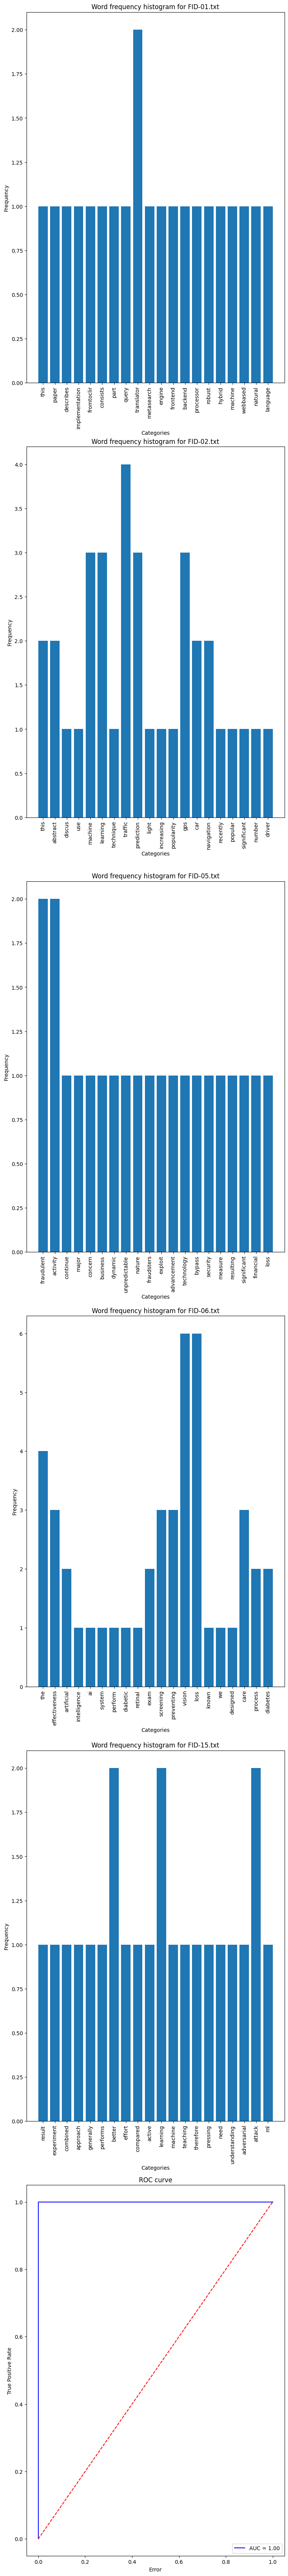

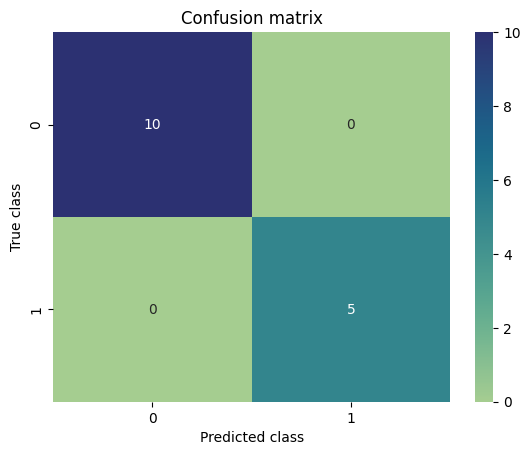

In [40]:
# Call the main system function to kick-off the plagiarism detector
decision("original_files", "suspicious_files")
